# Apprentissage machine

L'apprentissage machine est une branche empirique de l'intelligence artificielle. Ce carnet a pour but de donner une introduction à ses concepts en utilisant le module *Scikit-Learn*, ce véritable couteau suisse en science des données avec Python que nous avons introduit dans le carnet 6. *Scikit-Learn* est un module mature et [très bien documenté](https://scikit-learn.org/stable/user_guide.html).

## Flux de travail en apprentissage machine 

![](images/ml_workflow.png)

Je vais couvrir les concepts de base, y compris la séparation des données en ensembles d'entraînement et de test, la validation croisée, le prétraitement des données, et plusieurs types de modèles de machine learning. Je vais également discuter de l'importance des variables dans les modèles.

Je vais utiliser deux jeux de données pour nos exemples : `concrete-data.csv` et `penguins.csv`. Le premier contient des données sur différents mélanges de béton et leur résistance à la compression, ce qui est un sujet important en génie civil. Le deuxième, eh bien c'est le même que dans les autres carnets!

Nous allons explorer les modèles suivants.

- Les k proches voisins
- Les arbres de décision
- Les forêts aléatoires
- Le gradient boosting
- Les réseaux de neurones
- Les processus gaussiens

Je vais brièvement décrire chaque modèle, discuter de leurs avantages et inconvénients, puis montrer comment les utiliser avec *Scikit-Learn*.

In [ ]:
# Importation des modules nécessaires
!pip install polars==0.19 lets-plot==4.1
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from lets_plot import *
LetsPlot.setup_html()

# Importation des données
concrete_data = pl.read_csv('data/concrete-data.csv')
penguins_data = pl.read_csv('data/penguins.csv', null_values='NA')

Avec les données `concrete_data`, nous désirons prédire la résistance en compression, qui est une variable continue. En langage de machine learning, il s'agit d'une **régression**. Lorsqu'au contraire on désire prédire une catégorie, comme une espèce de manchot, on parlera d'une **classification**. Listons les *features* (variables prédictives) et les *targets* (variables cibles).

In [2]:
concrete_features = ['Cement (kg/m³)', 'Blast Furnace Slag (kg/m³)', 'Fly Ash (kg/m³)', 'Water (kg/m³)', 'Superplasticizer (kg/m³)', 'Coarse Aggregate (kg/m³)', 'Fine Aggregate (kg/m³)', 'Age (day)']
concrete_target = ['Compressive strength (MPa)']

penguins_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
penguins_target = ['species']


## Séparation des données en ensembles d'entraînement et de test

La première étape de la plupart des projets de machine learning est de diviser notre ensemble de données en un ensemble d'entraînement et un ensemble de test. L'ensemble d'entraînement est utilisé pour entraîner notre modèle, tandis que l'ensemble de test est utilisé pour évaluer sa performance. C'est important car cela nous permet de voir comment notre modèle se comporte sur des données qu'il n'a jamais vues auparavant, ce qui est une bonne indication de sa capacité à généraliser à de nouvelles données.

Nous allons utiliser la fonction `train_test_split` de Scikit-Learn pour faire cela. Nous allons diviser nos données en 80% pour l'entraînement et 20% pour le test.

In [3]:
# Séparation des données en ensembles d'entraînement et de test
## béton
X_concrete = concrete_data.drop('Compressive strength (MPa)')
y_concrete = concrete_data.select('Compressive strength (MPa)')
X_train_concrete, X_test_concrete, y_train_concrete, y_test_concrete = train_test_split(X_concrete, y_concrete, test_size=0.2, random_state=42)

Si les données sont trop peu nombreuses pour être séparées en lots d'entraînement et de test, on peut s'en sortir en faisant de la validation croisée. La technique de validation croisée la plus utilisée est le *k-fold*, qui consiste à séparer au hasard un tableau en un nombre *k* de tableaux. Itérativement, on met le tableau *i* de côté (*i* variant de 1 à *k*) pour lisser le modèle sur l'ensemble des autres tableaux. Enfin, on évalue la performance du modèle sur le tableau *i*. Le résultat est un nombre *k* d'indicateurs de performance du modèle. Nous n'utiliserons Si la performance est suffisante, on peut lisser le modèle final sur l'ensemble des données. Les *k-folds* demandent toutefois faire attention à la structure des données: voir la [fiche de *Scikit-Learn*](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) pour plus de détails. Nous utiliserons la validation croisée plus loin pour les machots avec la fonction [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [5]:
penguins_dataml = (
    penguins_data
    .select(penguins_features + penguins_target)
    .filter(pl.all_horizontal(pl.col(pl.Float32, pl.Float64).is_not_nan())) # enlever les NaN
    .drop_nulls() # enlever les None
)
X_penguins = penguins_dataml.select(penguins_features)
y_penguins = penguins_dataml.select(penguins_target)

## Prétraitement des données

Le prétraitement des données est une étape importante du machine learning. Il s'agit de transformer les données brutes en un format qui peut être facilement et efficacement traité par un modèle de machine learning. Il existe de nombreuses techniques de prétraitement des données, mais dans ce carnet, nous allons nous concentrer sur la standardisation, que nous avons par ailleurs déjà utilisée dans le carnet 6.

La standardisation est une technique de mise à l'échelle des données de sorte que la distribution des colonnes numériques ait une moyenne de 0 et un écart type de 1. Elle est particulièrement utile lorsque nous travaillons avec des modèles de machine learning qui utilisent une mesure de distance, comme les k plus proches voisins, ou lorsque nous travaillons avec des données qui ont des caractéristiques de différentes échelles.

Si l'on a préalablement séparé nos données en jeus d'entraînement et de test, la référence du prétraitement est le jeu d'entraînement. Nous allons utiliser la classe `StandardScaler` de Scikit-Learn pour standardiser nos données.

In [6]:
# Standardisation des données concrete
xscaler_concrete = StandardScaler()
X_train_concrete_sc = xscaler_concrete.fit(X_train_concrete)
X_train_concrete_sc = xscaler_concrete.transform(X_train_concrete)
X_test_concrete_sc = xscaler_concrete.transform(X_test_concrete)

yscaler_concrete = StandardScaler()
y_train_concrete_sc = yscaler_concrete.fit(y_train_concrete)
y_train_concrete_sc = yscaler_concrete.transform(y_train_concrete)
y_test_concrete_sc = yscaler_concrete.transform(y_test_concrete)

# Standardisation des données penguins
xscaler_penguins = StandardScaler()
X_penguins_sc = xscaler_penguins.fit_transform(X_penguins) # fit et transform d'un seul coup...

## Les *k* proches voisins

L'algorithme des *k* proches voisins (kNN, pour *k nearest neighbors*) est un type d'apprentissage basé sur l'instance, ou apprentissage paresseux, où la fonction n'est approximée qu'au niveau local et toutes les calculs sont différés jusqu'à la classification. L'algorithme kNN est parmi les plus simples de tous les algorithmes d'apprentissage automatique.

Les kNN forment un type d'apprentissage basé sur l'instance, ou apprentissage non généralisé : les kNN ne tentent pas de construire un modèle interne général, mais stocke simplement des instances des données d'entraînement. La **classification** est calculée à partir d'un vote majoritaire simple des k voisins les plus proches de chaque point : un point de requête est attribué à la classe de données qui a le plus de représentants parmi les *k* voisins les plus proches du point. Quant à la **régression**, le résultat est la tendance centrale (souvent la moyenne) des *k* voisins.

### Avantages

- L'algorithme est simple et facile à implémenter.
- Il n'y a pas besoin de construire un modèle, d'accorder plusieurs paramètres, ou de faire des hypothèses supplémentaires.
- L'algorithme est utile dans les cas de classification multiclasse (e.g. Adelie, Chinstrap, Gentoo).

### Inconvénients

- L'algorithme devient significativement plus lent à mesure que le nombre d'exemples et/ou de prédicteurs/augmente.
- L'algorithme est sensible aux variables non pertinentes et à l'échelle des données.
- Un mauvais choix de *k* peut entraîner de mauvais résultats.
- Les régressions ne donnent pas des réponses lisses.

Utilsons les kNN pour classifier les manchots. J'introduis du même coup la validation croisée. Lors des classifications, il est courrant de tenir compte des déséquilibres de classe dans les partitionnements, de sorte que chaque partition inclue une proportion semblable de chaque catégorie - nous utiliserons la fonction `StratifiedShuffleSplit`. Le débalancement des classes est non seulement un enjeu technique, mais aussi un enjeu éthique par rapport aux modèles d'IA, qui parfois ne sont pas adaptés à certaines classes démographiques peu représentés dans les données.

Définissons d'abord une instance du modèle KNeighborsClassifier, qui prendra 10 voisins (on pourrait essayer plusieurs valeurs de nombre de voisins).

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn_penguins = KNeighborsClassifier(n_neighbors=25)

Puis créons notre *splitter* pour les *k-folds*.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
penguins_splitter = StratifiedShuffleSplit(n_splits = 5)

Voyons voir les scores de notre validation croisée avec `cross_val_score`.

In [9]:
from sklearn.model_selection import cross_val_score
knn_penguins_scores = cross_val_score(
    estimator = knn_penguins,
    X = X_penguins_sc,
    y = y_penguins,
    cv = penguins_splitter,
    scoring = 'accuracy'
)

/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed 

Le score *accuracy* est la proportion d'observations bien classifiées. Il existe une panoplie de scores disponibles dans *Scikit-Learn* pour la classification et la régression. Pour les lister, lancez 

```
from sklearn.metrics import get_scorer_names
get_scorer_names()
```

Voyons les scores de notre validation croisée.

In [10]:
for i in range(len(knn_penguins_scores)):
    print(f"Accuracy du split {i}: {knn_penguins_scores[i]}")
print(f"Score moyen de la validation croisée: {knn_penguins_scores.mean()}")

Accuracy du split 0: 1.0
Accuracy du split 1: 1.0
Accuracy du split 2: 0.9714285714285714
Accuracy du split 3: 0.9714285714285714
Accuracy du split 4: 0.9714285714285714
Score moyen de la validation croisée: 0.9828571428571429


Cela semble très bien! Nous pouvons maintenant modéliser...

In [11]:
knn_penguins.fit(X = X_penguins_sc, y = y_penguins)

/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=25)

L'objet `knn_penguins` est maintenant lissé aux données. Il peut maintenant être utilisé pour prédire. Une manière d'apprécier un modèle de classification est de générer un tableau de contingence, aussi appelée la "matrice de confusion". *Polars*

In [12]:
from sklearn.metrics import confusion_matrix
y_penguins_pred = knn_penguins.predict(X_penguins_sc)
penguin_catnames = y_penguins.unique().sort(by = 'species').to_numpy().flatten().tolist()

(
    pl.DataFrame(confusion_matrix(y_penguins, y_penguins_pred), schema = penguin_catnames)
    .with_columns(pl.Series(penguin_catnames).alias('species'))
)

Adelie,Chinstrap,Gentoo,species
i64,i64,i64,str
151,0,0,"""Adelie"""
6,62,0,"""Chinstrap"""
0,0,123,"""Gentoo"""


Six observations de l'espèce adelie ont été incorrectement classées comme chinstrap. Si vous vous souvenez bien, dans le carnet 6, nous avions conclu que les chinstrap et les adelie était semblables selon les attributs utilisés.

Comment aurions-nous pu améliorer le modèle?

## Arbres de décision

Un arbre de décision est un type de modèle de machine learning qui fait des prédictions en divisant les données en différents sous-groupes basés sur les valeurs des variables d'entrée. C'est un type de modèle dit 'boîte blanche', ce qui signifie que les prédictions qu'il fait sont facilement interprétables et explicables.

### Avantages

- Facilité d'interprétation et de visualisation.
- Peut gérer à la fois des variables numériques et catégorielles.
- Peut gérer des problèmes de classification et de régression.

### Inconvénients

- Peut créer des modèles complexes qui ne généralisent pas bien les données (surapprentissage).
- Peut être sensible aux petites variations des données d'entraînement.
- Peut créer des arbres biaisés si certaines classes dominent.
- Les régressions ne donnent pas des réponses lisses

Utilisons les arbres pour la classification des manchots, mais cette fois sans la validation croisée, étant donné que nous l'avons déjà couverte. De plus, je n'utilise pas `X_penguins_sc`, mais bien `X_penguins`, car les arbres de décision ne sont pas sensibles à l'échelle.

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt_penguins = DecisionTreeClassifier(random_state=42)
dt_penguins.fit(X = X_penguins, y = y_penguins)
y_pred_penguins = dt_penguins.predict(X_penguins)
accuracy_penguins = metrics.accuracy_score(y_penguins, y_pred_penguins)
accuracy_penguins

1.0

Tous nos points sont bien classés. Un avantage des arbres de décision est que l'on peut les utiliser en imprimant un graphique, ce qui les rend facilement auditables.

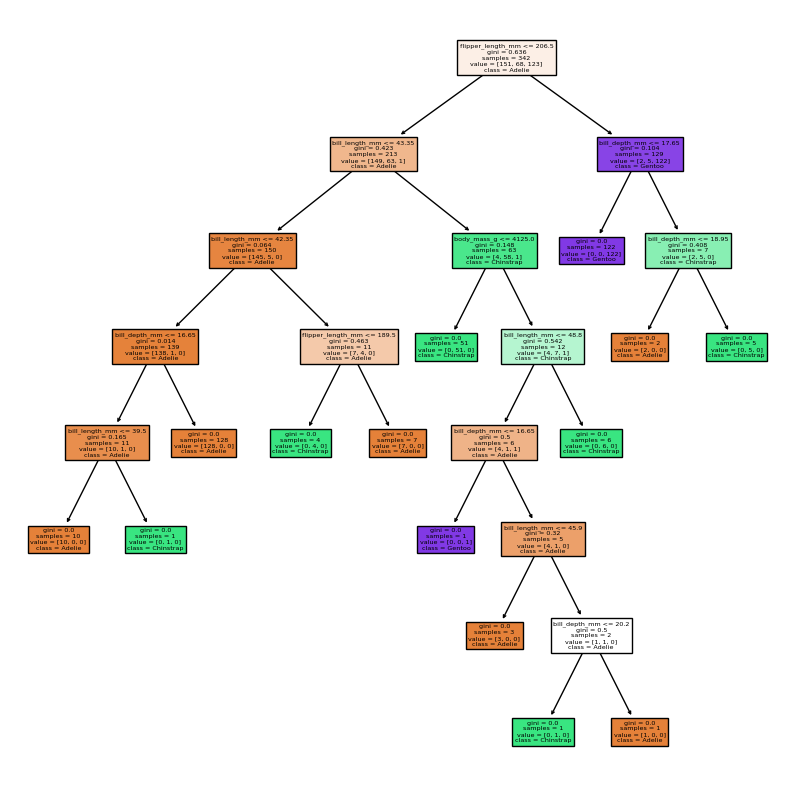

In [14]:
from sklearn import tree
import matplotlib.pyplot as plt # module graphique de base en Python
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(
    dt_penguins,
    feature_names = penguins_features,
    class_names = penguin_catnames,
    filled = True,
    ax = ax
);

## Forêts aléatoires

Une forêt aléatoire fonctionne en créant un grand nombre d'arbres de décision et en faisant la moyenne de leurs prédictions. Les forêts aléatoires sont un exemple de méthode d'ensemble, ce qui signifie qu'elles fonctionnent en combinant les prédictions de plusieurs modèles plus simples.

### Avantages

- Peut gérer un grand nombre de caractéristiques et de grandes quantités de données.
- Ne nécessite pas beaucoup de préparation des données (pas besoin de mise à l'échelle, etc.).
- Fournit une estimation de l'importance des caractéristiques.

### Inconvénients

- Moins interprétable qu'un arbre de décision unique.
- Peut surapprendre si le nombre d'arbres n'est pas bien réglé.
- Les régressions ne donnent pas des réponses lisses.

Nous allons, cette fois-ci, utiliser les données `concrete_data` pour prédire la résistence en compression d'un béton. Il s'agira donc d'une régression. Dans ce cas, nous lissons le modèle sur les données d'entraînement, puis l'évaluons sur les données test. Comme pour les arbres de décision, il est inutile de préalablement mettre les données à l'échelle.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf_concrete = RandomForestRegressor(random_state=42)
rf_concrete.fit(X_train_concrete, y_train_concrete)
y_pred_concrete = rf_concrete.predict(X_test_concrete)
r2_concrete = r2_score(y_test_concrete, y_pred_concrete)
print(f"Le R2 du modèle est de {r2_concrete}")

/var/folders/7p/wk_02tlx73db7yv0wvbxc1jh0000gn/T/ipykernel_94429/3092598347.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_concrete.fit(X_train_concrete, y_train_concrete)


Le R2 du modèle est de 0.8841401081258502


Une autre manière d'évaluer un modèle est de créer un graphique carré avec la valeur réelle en x et la valeur prédite en y. Si la prédiction est bonne, les points s'alligneront sur la pente de 45 degrés. Si les points s'allignent exactement, c'est un signe de surapprentissage.

In [16]:
dt_concrete_true_pred = pl.DataFrame(dict(
    observed = y_test_concrete.to_numpy().flatten(),
    predicted = y_pred_concrete
))

(
    ggplot(dt_concrete_true_pred, aes(x='observed', y='predicted'))
    + geom_point()
    + coord_fixed()
)

Un aspect intéressant des modèles de machine learning est qu'ils peuvent être conditionnés. Par exemple, je crée un tableau avec les mêmes caractéristiques répétées, à l'exception de l'âge. Je pourrais alors prédire comment la résistance en compression évoluera dans le temps.

In [19]:
conditioned_concrete = pl.DataFrame(
  {
    'Cement (kg/m³)': 420,
    'Blast Furnace Slag (kg/m³)': 50,
    'Fly Ash (kg/m³)': 10,
    'Water (kg/m³)': 150,
    'Superplasticizer (kg/m³)': 0,
    'Coarse Aggregate (kg/m³)': 900,
    'Fine Aggregate (kg/m³)': 800,
    'Age (day)': np.linspace(0, 150, 151)
  }
)

conditioned_concrete = (
    conditioned_concrete
    .with_columns(pl.Series(
        rf_concrete.predict(conditioned_concrete)
    ).alias('Predicted compressive strength with RF (MPa)'))
)

(
    ggplot(
        data = conditioned_concrete,
        mapping = aes(x='Age (day)', y='Predicted compressive strength with RF (MPa)')
    )
    + geom_line()
)

Dans les désavantages nommés plus haut, j'écrivais "les régressions ne donnent pas des réponses lisses". Vous voyez l'effet!

## Gradient Boosting

Le *gradient boosting* est semblable au *random forest*, mais qui est construit de sorte à modéliser d'abord les données, puis les erreurs sur les données. Ainsi, chaque nouvel arbre se concentre de plus en plus sur les difficultés rencontrées par les arbres précédents.  Il est en général très apprécié par la communauté du machine learning. Je vous invite à l'essayer à même ce carnet de calcul, pour le béton, avec `GradientBoostingRegressor`.

### Avantages

- Peut gérer des données de types mixtes.
- Peut gérer des problèmes de classification et de régression.
- Fournit une estimation de l'importance des caractéristiques.

### Inconvénients

- Moins interprétable qu'un arbre de décision unique.
- Peut surapprendre si le nombre d'arbres n'est pas bien réglé.
- Peut être sensible aux valeurs aberrantes.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

## Réseaux de neurones

Les réseaux de neurones sont un ensemble de techniques d'apprentissage automatique qui ont été inspirées par le fonctionnement du cerveau humain. Ils sont constitués de neurones artificiels, ou nœuds, qui sont connectés les uns aux autres et qui transmettent des signaux entre eux.

Les principes sont simples...

VOIR RAPPORT

### Avantages

- Peuvent modéliser des relations complexes et non linéaires.
- Peuvent apprendre à partir de données brutes, ce qui signifie qu'ils peuvent souvent éviter le besoin d'un prétraitement manuel des données.
- Sont particulièrement efficaces pour les problèmes de classification et de régression.

### Inconvénients

- Peuvent nécessiter beaucoup de temps et de ressources pour s'entraîner.
- Sont souvent considérés comme une boîte noire, ce qui signifie qu'il peut être difficile de comprendre pourquoi ils font certaines prédictions.
- Peuvent surapprendre si le nombre de neurones et de couches n'est pas bien réglé.

Nous allons, de nouveau, modéliser la résistance en compression du béton. Mais cette fois-ci, nous utiliserons le tableau mis à l'échelle `X_train_concrete_sc`.

In [21]:
from sklearn.neural_network import MLPRegressor

nn_concrete = MLPRegressor(
    hidden_layer_sizes = (32, 32, 32),
    activation = 'relu',
    solver = 'adam'
)
nn_concrete.fit(X_train_concrete_sc, y_train_concrete_sc)
y_pred_concrete_sc = nn_concrete.predict(X_test_concrete_sc)

r2_concrete = r2_score(y_test_concrete_sc, y_pred_concrete_sc)
print(f"Le R2 du modèle est de {r2_concrete}")

nn_concrete_true_pred = pl.DataFrame(dict(
    observed = y_test_concrete_sc.flatten(),
    predicted = y_pred_concrete_sc
))

(
    ggplot(nn_concrete_true_pred, aes(x='observed', y='predicted'))
    + geom_point()
    + coord_fixed()
)


/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le R2 du modèle est de 0.8904701121544725


/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
# Mettre X à l'échelle transformée
conditioned_concrete_sc = (
    xscaler_concrete
    .transform(conditioned_concrete.select(concrete_features))
)

# Prédire y
y_pred_sc = nn_concrete.predict(conditioned_concrete_sc)
y_pred = yscaler_concrete.inverse_transform(y_pred_sc.reshape(-1, 1))
conditioned_concrete = (
    conditioned_concrete
    .with_columns(
        pl.Series(y_pred.flatten()).alias('Predicted compressive strength with NN (MPa)')
    )
)

(
    ggplot(
        data = conditioned_concrete,
        mapping = aes(x='Age (day)', y='Predicted compressive strength with NN (MPa)')
    )
    + geom_line()
)

## Processus gaussiens

Un processus gaussien est une généralisation de la distribution normale multivariée à un nombre infini de dimensions, défini par une fonction de moyenne et une fonction de covariance. En centrant la variable de sortie, on peut dans la plupart des cas supposer que la moyenne est toujours nulle, et on ne définira qu'une fonction de covariance (aussi appelée noyau, ou *kernel*). Chaque point dans un certain espace continu est associé à une variable aléatoire normalement distribuée. Une fois conditionnée aux observations, on aura une idée de la prédiction en échantillonnant plusieurs observations aléatoires. Le résultat sera une distribution de probabilité, de laquelle on pourra extraire la moyenne pour avoir une estimation ponctuelle.

### Avantages

- Peut modéliser des relations complexes et non linéaires.
- Fournit des mesures d'incertitude avec les prédictions.
- Très flexible grâce à la sélection du noyau.

### Inconvénients

- Le temps de calcul peut être très long pour les grands ensembles de données.
- Le choix du noyau et des paramètres du noyau peut avoir un grand impact sur les performances du modèle.

**Important**. La valeur par défaut de `alpha` de la fonction `GaussianProcessRgressor` est de 1E-10.  C'est très faible. Cette valeur doit être ramenée à environ 0.5 pour que le modèle fonctionne. Donc n'oubliez jamais de spécifier `alpha`!

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Noyau
## le multiplicateur (0.5) défini l'amplitude possible du signal
## lenght_scale est optimisée, elle défini la fréquence possible du signal
gp_kernel = RBF(length_scale = 1.0)
gp_concrete = GaussianProcessRegressor(alpha = 0.5, kernel = gp_kernel)
gp_concrete.fit(X_train_concrete_sc, y_train_concrete_sc)
y_pred_concrete_sc = gp_concrete.predict(X_test_concrete_sc)
r2_concrete = r2_score(y_test_concrete_sc, y_pred_concrete_sc)
print(f"Le R2 du modèle est de {r2_concrete}")

gp_concrete_true_pred = pl.DataFrame(dict(
    observed = y_test_concrete_sc.flatten(),
    predicted = y_pred_concrete_sc
))

(
    ggplot(gp_concrete_true_pred, aes(x='observed', y='predicted'))
    + geom_point()
    + coord_fixed()
)

Le R2 du modèle est de 0.8240288703502374


Rappelons-nous que les processus gaussiens génèrent des distributions. Les points que vous voyez sur le graphique précédent sont les tendances centrales obtenues par la méthode `.predict()`. Des échantillons pris au hasard dans la distribution sont accessibles par la méthode `.sample_y()`.

In [24]:
# Prédire y
y_pred_sc = gp_concrete.predict(conditioned_concrete_sc)
y_samples_sc = gp_concrete.sample_y(conditioned_concrete_sc, n_samples=50)
y_samples_sc.shape

(151, 50)

Remettons la résistance en compression dans son échelle originale, puis mettons en forme un tableau propre à être représenté graphiquement sur *Lets-Plot*.

In [25]:
y_pred = yscaler_concrete.inverse_transform(y_pred_sc.reshape(-1, 1))
sample_name = ['sample ' + str(i) for i in range(y_samples_sc.shape[1])]
y_samples = pl.DataFrame(
    yscaler_concrete.inverse_transform(y_samples_sc),
    schema = sample_name
)

In [26]:
conditioned_concrete = (
    conditioned_concrete
    .with_columns(
        pl.Series(y_pred.flatten()).alias('Predicted compressive strength with GP (MPa)')
    )
)

y_samples_tidy = (
    y_samples
    .with_columns(conditioned_concrete['Age (day)'])
    .melt(id_vars='Age (day)', value_name='Predicted compressive strength with GP (MPa)')
)

(
    ggplot()
    + geom_line(
        data=y_samples_tidy,
        mapping=aes(x='Age (day)', y='Predicted compressive strength with GP (MPa)', group='variable'),
        color='#CCCCCC'
    )
    + geom_line(
        data = conditioned_concrete,
        mapping = aes(x='Age (day)', y='Predicted compressive strength with GP (MPa)'),
        size=2
    )
)

## Importance des variables

L'importance des variables est une technique qui attribue un score à chaque variable d'entrée en fonction de la quantité d'information que cette variable apporte pour prédire la variable cible. C'est une technique très utile pour comprendre quels sont les facteurs les plus influents dans notre modèle. La manière de calculer les scores d'importance diffère d'un modèle à l'autre. Certains modèles, comme les réseaux de neurones et les processus gaussiens, n'offrent pas la méthode `.feature_importances_`.

Nous allons calculer l'importance des variables pour notre modèle d'arbre de décision.

In [27]:
fi_penguins = pl.DataFrame({
    'Feature': penguins_features,
    'Importance': dt_penguins.feature_importances_
}).sort(by = 'Importance')

ggplot(fi_penguins, aes(x='Feature', y='Importance')) + geom_lollipop() + coord_flip()